## Outline:
1. Time Series Analysis - Seasonality
2. Exercises Apriori Analysis - Association
3. Customer Clustering Analysis - Similarity <br>
    3.1 PCA<br>
    3.2 Kmeans
4. Summary 

In [14]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# load data sets
data = pd.read_csv('fitbod_JFANG_20191029-142511.csv')
data.head()

,singleSetId,weight,reps,distance,duration,elevationGain,setNumber,exerciseSetParseId,exerciseName,workoutId,workoutDate,fake_user_id
0,9ryvYFIb7b,0.0,0.0,6757.5,3367.0,45.000000,1,PScNySOoGX,Hiking,9zlFW13kdR,11/8/18,fake_id_903
1,au2KLtQH0Y,0.0,0.0,4473.5,2317.0,24.000000,1,Kr895qjV3g,Hiking,6QX2NKyeK2,6/21/19,fake_id_903
2,u1MlzlN8Ua,0.0,0.0,7404.5,2394.0,18.200001,1,TqjyQ9M1x5,Running,TcZWaSlJY4,4/28/18,fake_id_903
3,2FIknPIeTJ,0.0,10.0,NaN,NaN,NaN,4,yohv1Fikh4,Tricep Dip,8FHpAYEkn7,7/1/17,fake_id_904
4,gXwM1CxHST,140.0,10.0,NaN,NaN,NaN,2,aluFx0nljJ,Seated Back Extension,hPHRnuOr9f,12/27/16,fake_id_905


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29409 entries, 0 to 29408
Data columns (total 12 columns):
singleSetId           29409 non-null object
weight                29407 non-null float64
reps                  29407 non-null float64
distance              23775 non-null float64
duration              23775 non-null float64
elevationGain         23775 non-null float64
setNumber             29409 non-null int64
exerciseSetParseId    29409 non-null object
exerciseName          29380 non-null object
workoutId             29409 non-null object
workoutDate           29409 non-null object
fake_user_id          29409 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 2.7+ MB


In [20]:
# Add some columns to parse the date
data['workoutDate'] =  pd.to_datetime(data['workoutDate']).dt.date
data['day'] =  pd.DatetimeIndex(data['workoutDate']).day
data['month'] =  pd.DatetimeIndex(data['workoutDate']).month
data['year'] =  pd.DatetimeIndex(data['workoutDate']).year
data['month_year'] = pd.to_datetime(data['workoutDate']).dt.to_period('M')
data["weekday"]=data.apply(lambda row: row["workoutDate"].weekday(),axis=1)
data["is_weekday"] = (data["weekday"] < 5).astype(int)

In [21]:
# Show the unique numbers in each column
for column in data.columns:
    uniques = sorted(data[column].unique().astype(str))
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

singleSetId          29382	 ['006w6X9Cft', '008C56mKIP', '00OE6SUZq5', '00xEo8jLnw', '00yokyakGo']
weight                 255	 ['0.0', '0.045359290999999996', '0.453592909', '1.0', '1.133982274']
reps                    49	 ['0.0', '1.0', '10.0', '11.0', '12.0']
distance               366	 ['0.0', '1000.0', '1010.0', '10106.68032', '1027.2908289999998']
duration               367	 ['0.0', '10.0', '1004.3', '1006.0', '10072.0']
elevationGain           51	 ['0.0', '0.30479999', '0.60959998', '107.0', '11.0']
setNumber               10	 ['1', '10', '2', '3', '4']
exerciseSetParseId    9049	 ['00Sy7ojR5P', '00ZQHIsl9q', '00axuTy9tl', '00yeOkaHTT', '01FR68VcCP']
exerciseName           452	 ['Ab Crunch Machine', 'Ab Rollout', 'Abs Bike', 'Abs Complex', 'Air Squats']
workoutId             1532	 ['07EoSnZrc1', '0FT71aEpg1', '0H7CAOV3U2', '0HxetuDItg', '0MI2yd98sr']
workoutDate            713	 ['2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-25']
fake_user_id            12	 ['f

**Dataset Assumption:**
    
There are 12 distinct users in this dataset. Each time they use our app, there is an workoutId generated.

For each workoutId, there could be multiple exerciseSetParseId which indicates the type of workouts. 

For each exerciseSetParseId, there could be multiple singleSetId as a user might do the same workout many times.

# 1. Time Series Analysis

In [22]:
grouped_by_YM = data.groupby(['year','month','day']).size().reset_index(name='count')
grouped_by_YM.sort_values(['year','month','day'],ascending = True, inplace = True)
grouped_by_YM

,year,month,day,count
0,2016,12,19,17
1,2016,12,20,31
2,2016,12,21,23
3,2016,12,22,38
4,2016,12,25,27
...,...,...,...,...
708,2019,9,7,93
709,2019,9,9,33
710,2019,9,10,58
711,2019,9,11,54


It looks like in the dataset we only have December for 2016, let's just get rid of it.

In [23]:
grouped_by_YM=grouped_by_YM[grouped_by_YM['year']!=2016]

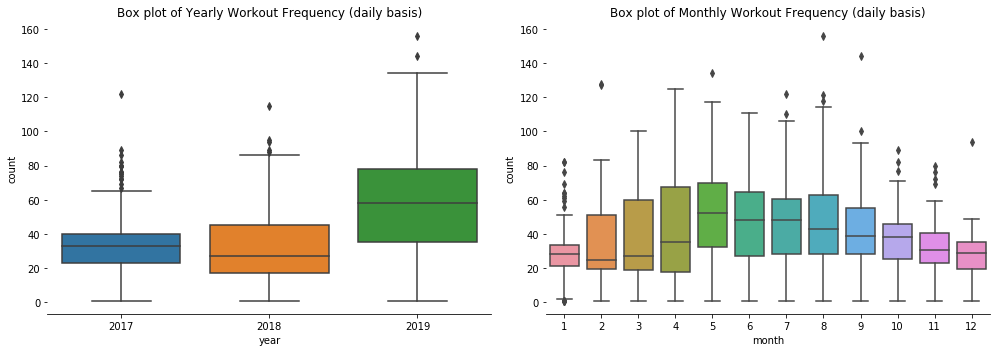

In [25]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="count", data=grouped_by_YM)
plt.xlabel('year')
plt.title('Box plot of Yearly Workout Frequency (daily basis)')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="month", y="count", data=grouped_by_YM)
plt.xlabel('month')
plt.title('Box plot of Monthly Workout Frequency (daily basis)')
sns.despine(left=True)
plt.tight_layout();

A **boxplot** is a standardized way of displaying the distribution of data based on a five number summary 
(“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).

1. Growing pattern: users exercise more
2. Seasonality pattern: People are more active in summer


### Now let's take a look at the data across time series

In [9]:
data_not_2016=data[data['year']!=2016]
grouped_by_date = data_not_2016.groupby(['workoutDate']).size().reset_index(name='count')
grouped_by_date=grouped_by_date[grouped_by_date['workoutDate']!=2016]
grouped_by_date.set_index('workoutDate',inplace=True)

In [10]:
grouped_by_date.index=pd.to_datetime(grouped_by_date.index)
grouped_by_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 705 entries, 2017-01-01 to 2019-09-12
Data columns (total 1 columns):
count    705 non-null int64
dtypes: int64(1)
memory usage: 11.0 KB


In [65]:
grouped_by_date

,count
workoutDate,
2017-01-01,23
2017-01-03,34
2017-01-06,24
2017-01-08,23
2017-01-09,19
...,...
2019-09-07,93
2019-09-09,33
2019-09-10,58


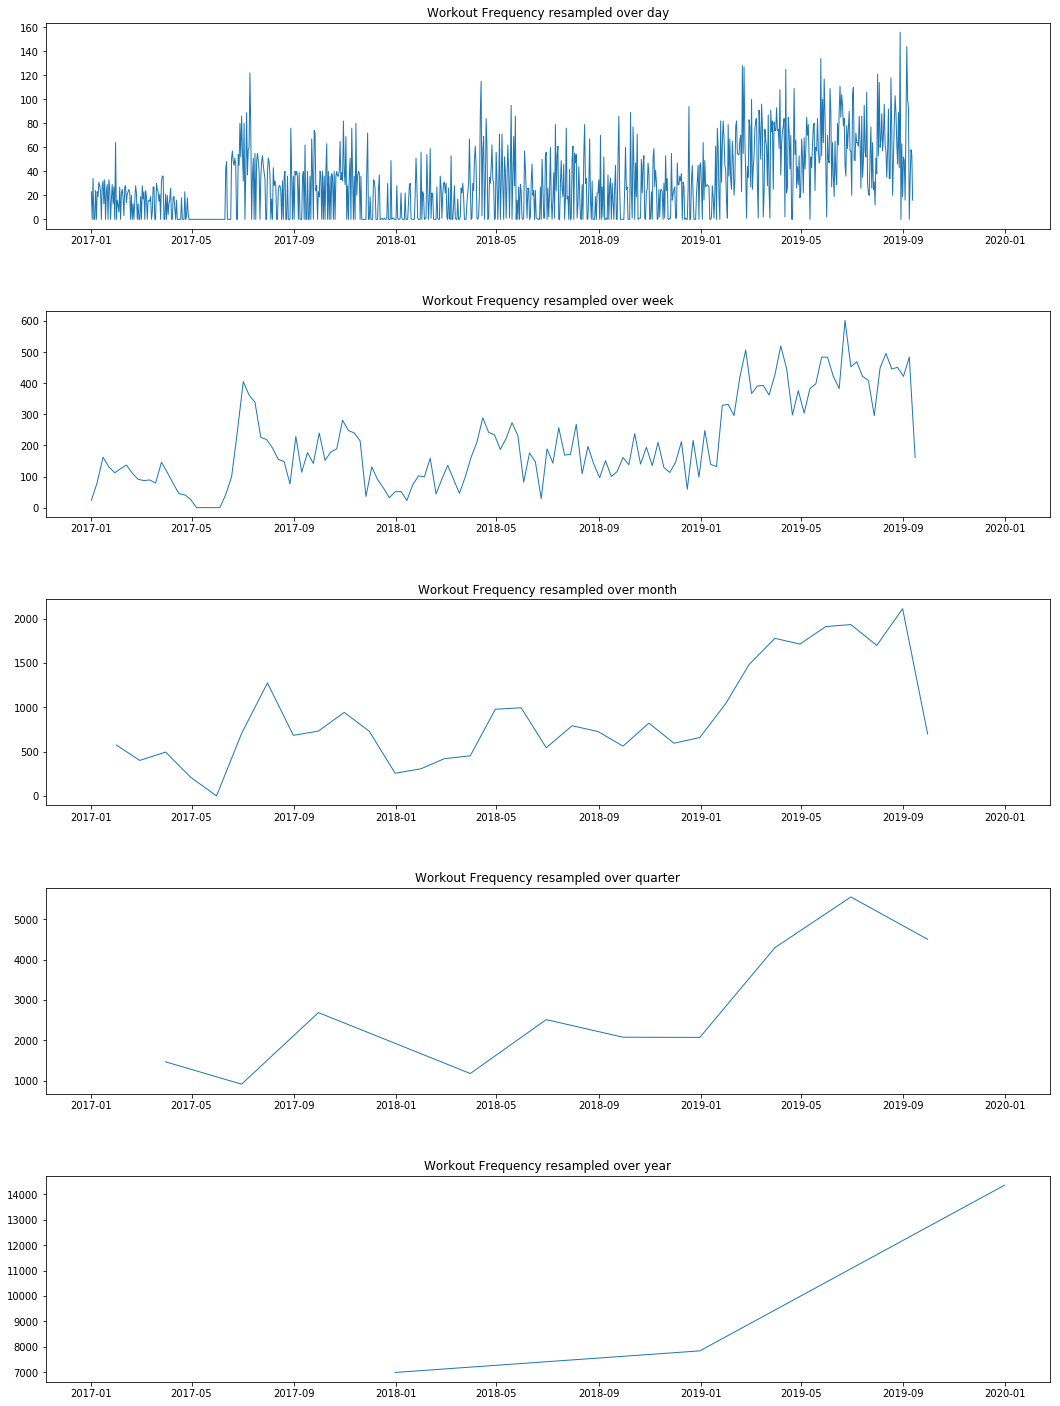

In [107]:
fig = plt.figure(figsize=(18,25))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(grouped_by_date['count'].resample('D').sum(),linewidth=1)
ax1.set_title('Workout Frequency resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(grouped_by_date['count'].resample('W').sum(),linewidth=1)
ax2.set_title('Workout Frequency resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(grouped_by_date['count'].resample('M').sum(),linewidth=1)
ax3.set_title('Workout Frequency resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(grouped_by_date['count'].resample('Q').sum(),linewidth=1)
ax4.set_title('Workout Frequency resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(grouped_by_date['count'].resample('A').sum(),linewidth=1)
ax5.set_title('Workout Frequency resampled over year')
ax5.tick_params(axis='both', which='major');

1. In general, our time series has a upward trend.
2. The year by year increasement is growing exponentially. 

### Let now take a look at the difference between weekends and weekdays

In [64]:
grouped = data_not_2016.groupby(['year','is_weekday']).size().reset_index(name='count')
grouped.sort_values(['count'],ascending = True, inplace = True)
grouped

,year,is_weekday,count
2,2018,0,1386
0,2017,0,1417
4,2019,0,3648
1,2017,1,5578
3,2018,1,6457
5,2019,1,10709


/Users/apple/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/apple/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


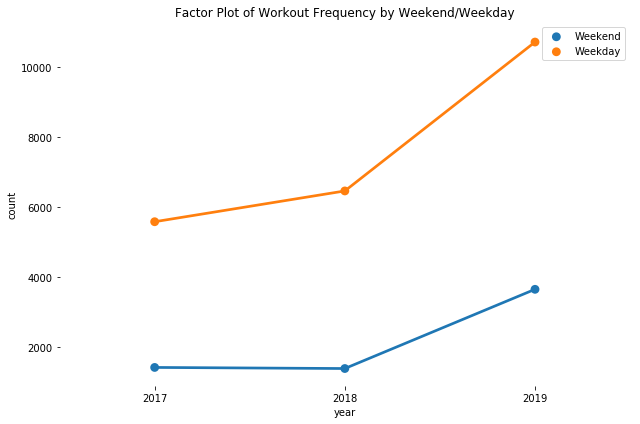

In [59]:
dic={0:'Weekend',1:'Weekday'}
grouped['day'] = grouped.is_weekday.map(dic)
plt1=sns.factorplot(x='year', y='count', hue='day',data=grouped, size=6, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Workout Frequency by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

1. People tend to work out more during weekdays
2. The difference between workout on weekdays and weekends are increasing over years.

# 2. Apriori Analysis

Apriori is an assiociation algorithm to find out what exercises are frequently done together.

In [14]:
from apyori import apriori

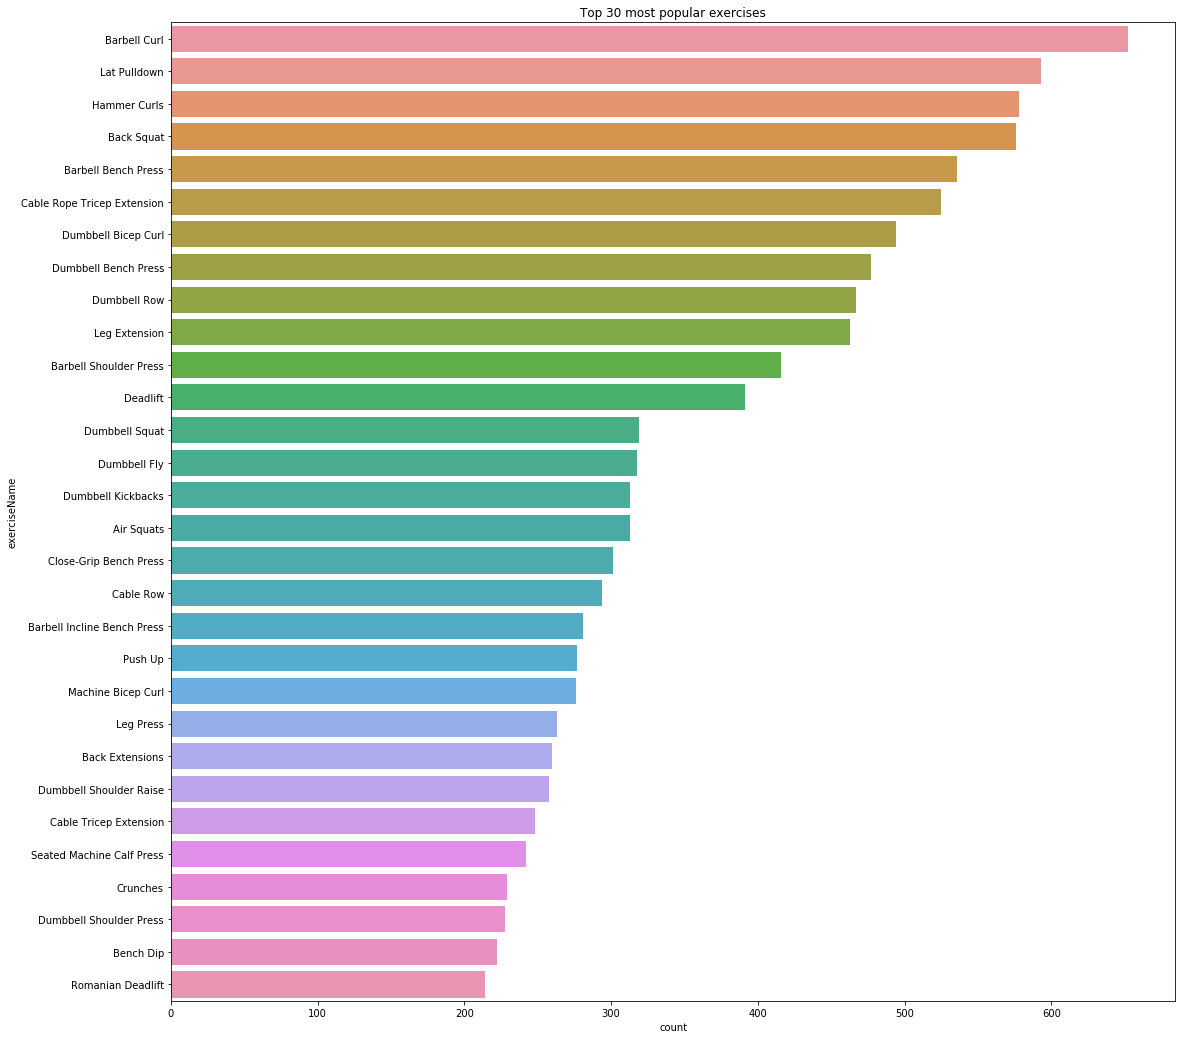

In [28]:
grouped_by_exercise = data.groupby('exerciseName').size().reset_index(name='count')
grouped_by_exercise.sort_values(by=['count'],ascending=False,inplace=True)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))
bar_plot=sns.barplot(x='count', y='exerciseName',data=grouped_by_exercise[:30],ax=ax)
# plt.xticks( rotation='vertical')
plt.title("Top 30 most popular exercises")
plt.show()

In [15]:
# Manipulate the original dataframe to get a list of lists where each list is the work out being done in the same workout session.
data['exerciseName']=data.exerciseName.astype(str)
records=list(data.groupby('workoutId').exerciseName.agg(list).values)
records[:3]

[['Running'],
 ['Hammer Curls',
  'Lat Pulldown',
  'Assisted Pull Up',
  'Assisted Pull Up',
  'T-Bar Row',
  'Ab Crunch Machine',
  'Lat Pulldown',
  'Assisted Pull Up',
  'Hammer Curls',
  'T-Bar Row',
  'Dumbbell Row',
  'Dumbbell Shrug',
  'Lat Pulldown',
  'Assisted Pull Up',
  'Ab Crunch Machine',
  'Assisted Pull Up',
  'Lat Pulldown',
  'T-Bar Row',
  'Lat Pulldown',
  'Barbell Curl',
  'Lat Pulldown',
  'Barbell Curl',
  'Lat Pulldown',
  'Dumbbell Row',
  'Assisted Pull Up',
  'Assisted Pull Up',
  'Barbell Curl',
  'Lat Pulldown',
  'T-Bar Row',
  'Dumbbell Shrug',
  'Single Arm Preacher Curl',
  'Dumbbell Shrug',
  'Single Arm Preacher Curl',
  'Hammer Curls',
  'Ab Crunch Machine',
  'Assisted Pull Up'],
 ['Barbell Bench Press',
  'Leg Pull-In',
  'Barbell Curl',
  'Barbell Bench Press',
  'Leg Pull-In',
  'Barbell Curl',
  'Barbell Bench Press',
  'Barbell Curl',
  'Single Arm Dumbbell Bench Press',
  'Superman',
  'Superman',
  'Hammer Curls',
  'Hammer Curls',
  'Dumbb

Before fit the data into the algorithm, let's get familiar with some measurements.

**Support**. This says how popular an exercise set is.

=> (#workout sessions contain X)/(#total workout sessions)

**Confidence**. This says how likely exercise Y is done when exercise X is done

=> (#workout sessions contain X and Y)/(#workout sessions contain X)

[Limitation: it only accounts for how popular X are, but not Y. If Y are also very popular in general, there will be a higher chance that a workout sessions containing X will also contain Y, thus inflating the confidence measure.]

**Lift**. This says how likely Y is done when exercise X is done, while controlling for how popular exercise Y is.

=> Support(X,Y)/(Support(X)*Support(Y))

In [16]:
association_rules = apriori(records, min_support=0.01, min_confidence=0.5, min_lift=20, min_length=2)
association_results = list(association_rules)

In [17]:
for item in association_results:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
  
    
    print("Rule: " + str(list(item.ordered_statistics[0].items_base)) + " -> " + str(list(item.ordered_statistics[0].items_add)))

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: ['Handle Band Bent Over Row'] -> ['Handle Band Rear Deltoid Fly']
Support: 0.011096605744125326
Confidence: 0.8500000000000001
Lift: 72.34444444444445
Rule: ['Handle Band Bent Over Row'] -> ['Handle Band Row']
Support: 0.010443864229765013
Confidence: 0.8
Lift: 64.50526315789475
Rule: ['Handle Band Bent Over Row'] -> ['Loop Band Shoulder Squeeze']
Support: 0.011096605744125326
Confidence: 0.8500000000000001
Lift: 68.53684210526316
Rule: ['Handle Band Rear Deltoid Fly'] -> ['Handle Band Row']
Support: 0.010443864229765013
Confidence: 0.888888888888889
Lift: 71.67251461988305
Rule: ['Handle Band Rear Deltoid Fly'] -> ['Loop Band Shoulder Squeeze']
Support: 0.011096605744125326
Confidence: 0.9444444444444444
Lift: 76.15204678362574
Rule: ['Handle Band Row'] -> ['Loop Band Shoulder Squeeze']
Support: 0.01174934725848564
Confidence: 0.9473684210526316
Lift: 76.38781163434903
Rule: ['Leg Raises with Stability Ball'] -> ['Overhead Weighted Sit Up']
Support: 0.015665796344647518
Confiden

Rule Explanation Example:
For the frist rule in the above list

**Rule: ['Handle Band Bent Over Row'] -> ['Handle Band Rear Deltoid Fly']**

Support: 0.011096605744125326

Confidence: 0.8500000000000001

Lift: 72.34444444444445

1.Handle Band Bent Over Row and Handle Band Rear Deltoid Fly are commonly done together

2.Support is 0.011 meaning out of all the workoutsessions, 1.1% include Handle Band Bent Over Row and Handle Band Rear Deltoid Fly together.

3.The confidence for this rule is 0.85 which means that out of all the workout sessions containing Handle Band Bent Over Row, 85% of the workout sessions have Handle Band Rear Deltoid Fly as well.

4.Lift of 72 shows the likelihood of doing Handle Band Bent Over Row and Handle Band Rear Deltoid Fly together together is 72 times more than the likelihood of just doing Handle Band Bent Over Row.

In [18]:
def concat2Frame(association_results):
    results = []
    for item in association_results:
        lhs = " - ".join(list(item[2][0].items_base))
        rhs = " - ".join(list(item[2][0].items_add))
        support = item.support
        confidence = item[2][0].confidence
        lift = item[2][0].lift
        rows = (lhs, rhs,support,confidence,lift)
        results.append(rows)

    #out of the for
    labels = ['LHS','RHS','Support','Confidence','Lift']
    rules_out = pd.DataFrame.from_records(results, columns = labels)
    return rules_out

In [19]:
result1=concat2Frame(association_results)
result1.sort_values(by=['Lift','Confidence'],ascending=[False,False],inplace=True)

In [20]:
result1

,LHS,RHS,Support,Confidence,Lift
34,Handle Band Rear Deltoid Fly - Handle Band Ben...,Loop Band Shoulder Squeeze,0.011097,1.000000,80.631579
35,Handle Band Row - Handle Band Bent Over Row,Loop Band Shoulder Squeeze,0.010444,1.000000,80.631579
36,Handle Band Row - Handle Band Rear Deltoid Fly,Loop Band Shoulder Squeeze,0.010444,1.000000,80.631579
53,Handle Band Row - Handle Band Rear Deltoid Fly...,Loop Band Shoulder Squeeze,0.010444,1.000000,80.631579
5,Handle Band Row,Loop Band Shoulder Squeeze,0.011749,0.947368,76.387812
4,Handle Band Rear Deltoid Fly,Loop Band Shoulder Squeeze,0.011097,0.944444,76.152047
33,Handle Band Rear Deltoid Fly - Handle Band Ben...,Handle Band Row,0.010444,0.941176,75.888545
0,Handle Band Bent Over Row,Handle Band Rear Deltoid Fly,0.011097,0.850000,72.344444
3,Handle Band Rear Deltoid Fly,Handle Band Row,0.010444,0.888889,71.672515
2,Handle Band Bent Over Row,Loop Band Shoulder Squeeze,0.011097,0.850000,68.536842


These association rules can serve as a reference when we trying to creat workout recommendation or workout groups.

# 3. Clustering Analysis

Let's find which customers are more similar

In [32]:
df=data.groupby(['fake_user_id','year'])['workoutId'].unique().to_frame()
df['count']=[len(i) for i in df['workoutId']]

In [33]:
df.reset_index(inplace=True)

In [34]:
df

,fake_user_id,year,workoutId,count
0,fake_id_903,2017,"[6M6lYxg8rS, L1ljrjqBYP, Jn79qNr31x, X5KL5AQOf...",7
1,fake_id_903,2018,"[9zlFW13kdR, TcZWaSlJY4, VgcbcMhrQE, EyjryoLHX...",175
2,fake_id_903,2019,"[6QX2NKyeK2, LimJZjFbdZ, NOn5QH1Y1p, D4h8ksHkE...",114
3,fake_id_904,2017,"[8FHpAYEkn7, LVCIO7IGKd, zVIuDtY66D, KLcGffRYX...",42
4,fake_id_904,2018,"[lLXyYfhGF2, 1gTJPs4ixD, tWGDXOHiQ7]",3
5,fake_id_905,2016,"[hPHRnuOr9f, fA1kyknlQh, YrgBj4wH1y, CGXHly94C...",8
6,fake_id_905,2017,"[6tupDIxgYe, ikVk24n9G4, igkPyICrRj, DwFpLRgOU...",108
7,fake_id_906,2017,"[3E4P8THvrL, 8S6xLf7vIQ, zRk5uLDZuT, rVn6aZ4IJ...",100
8,fake_id_907,2018,"[xN3NvOPeum, 6yRciM5teC, fVKyQ3hiUj, J3896J9o3...",172
9,fake_id_907,2019,"[7w5kKaOcsB, HyrXx6odEH, 43JixewgsN, mfvRzeAtG...",168


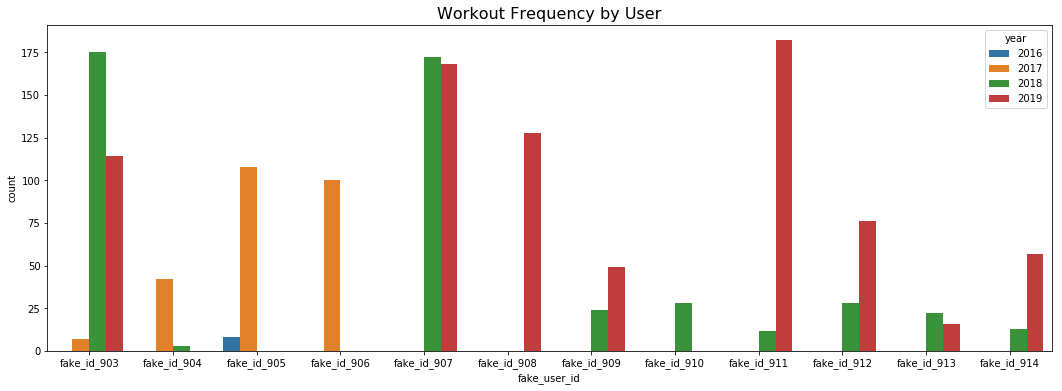

In [35]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
bar_plot=sns.barplot(x='fake_user_id', y='count',hue='year' ,data=df,ax=ax)
ax.set_title('Workout Frequency by User', fontsize=16)

plt.show()


It looks like we have already lost 904, 905, 906, 910 and we just acquired 908 this year.

In [36]:
# We are performing clustering on current active users.
activeUserId=['fake_id_903', 'fake_id_907', 'fake_id_908', 'fake_id_909',
       'fake_id_911', 'fake_id_912', 'fake_id_913', 'fake_id_914']

In [37]:
active_user=data[data['fake_user_id'].isin(activeUserId)]

In [38]:
active_user

,singleSetId,weight,reps,distance,duration,elevationGain,setNumber,exerciseSetParseId,exerciseName,workoutId,workoutDate,fake_user_id,month,year,month_year,weekday,is_weekday,day
0,9ryvYFIb7b,0.000000,0.0,6757.5000,3367.0,45.000000,1,PScNySOoGX,Hiking,9zlFW13kdR,2018-11-08,fake_id_903,11,2018,2018-11,3,1,8
1,au2KLtQH0Y,0.000000,0.0,4473.5000,2317.0,24.000000,1,Kr895qjV3g,Hiking,6QX2NKyeK2,2019-06-21,fake_id_903,6,2019,2019-06,4,1,21
2,u1MlzlN8Ua,0.000000,0.0,7404.5000,2394.0,18.200001,1,TqjyQ9M1x5,Running,TcZWaSlJY4,2018-04-28,fake_id_903,4,2018,2018-04,5,0,28
11,1ZpCRi3ULc,5.443115,10.0,0.0000,0.0,0.000000,4,zRPXPmSLuB,Floor Press,xN3NvOPeum,2018-07-18,fake_id_907,7,2018,2018-07,2,1,18
43,6rVbmb8YNC,0.000000,0.0,4184.2944,1800.0,0.000000,1,cl14kkv1vD,Elliptical,LimJZjFbdZ,2019-04-13,fake_id_903,4,2019,2019-04,5,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29401,sgVnb8Arjq,18.143716,3.0,0.0000,0.0,0.000000,1,6RPmXOBBPT,Hammer Curls,5SxLiQZo3X,2019-05-25,fake_id_909,5,2019,2019-05,5,0,25
29402,VYcao9DG66,11.339823,12.0,0.0000,0.0,0.000000,3,JGRzezBRRy,Hammer Curls,9LWfGmiJ8L,2019-08-26,fake_id_911,8,2019,2019-08,0,1,26
29403,wLn472ewKE,5.669911,10.0,0.0000,0.0,0.000000,1,gVM3MlIV6o,Hammer Curls,9vzessCUd8,2018-04-13,fake_id_907,4,2018,2018-04,4,1,13
29404,E5A2U6bkrw,11.339823,8.0,0.0000,0.0,0.000000,4,5dAxLSXFav,Hammer Curls,b0fsLrQiLK,2019-05-15,fake_id_911,5,2019,2019-05,2,1,15


Create some new features based on RFM model.
R->Recency F->Frequency M->Monetary

In [39]:
active_user['workoutDate'].max()

datetime.date(2019, 9, 12)

In [40]:
from datetime import datetime, timedelta,date
df_RFM = active_user.groupby('fake_user_id').agg({
                                        'workoutDate': lambda y: (date(2019,9,12) - y.max()).days,
                                        'workoutId': lambda y: len(y.unique()),  
                                        'singleSetId': lambda y: len(y.unique())
                                    }).reset_index()
                                       

In [41]:
df_RFM.rename(columns={"workoutDate": "recency", "workoutId": "workout_times","singleSetId":"setCount"},inplace=True)

In [42]:
df_RFM

,fake_user_id,recency,workout_times,setCount
0,fake_id_903,44,296,2387
1,fake_id_907,0,340,5966
2,fake_id_908,3,128,3152
3,fake_id_909,3,73,1449
4,fake_id_911,1,194,4189
5,fake_id_912,2,104,2453
6,fake_id_913,99,38,881
7,fake_id_914,7,70,1111


In [43]:
df=active_user.groupby(['fake_user_id','weekday'])['workoutId'].unique().to_frame()
df['count']=[len(i) for i in df['workoutId']]

In [45]:
df.reset_index(inplace=True)
df.head()

,index,fake_user_id,weekday,workoutId,count
0,0,fake_id_903,0,"[EyjryoLHX8, 4tKfjEhFSu, 5dJPdicsSW, 2Os18PMBI...",67
1,1,fake_id_903,1,"[BYrLFebLfj, 97SLaTQEXT, 5eM0oGmtMo, wDKieFHn9...",47
2,2,fake_id_903,2,"[NOn5QH1Y1p, D4h8ksHkEl, NyKChNzzcV, OFqWgzDYJ...",33
3,3,fake_id_903,3,"[9zlFW13kdR, 2gFRI3yQt7, FUA0VvgDYS, L9EhGqWW7...",32
4,4,fake_id_903,4,"[6QX2NKyeK2, IQogJKbVp8, M3S3nBfUUT, 4FD9sxQra...",46


In [48]:
sns.barplot(x='fake_user_id', y='count',hue='weekday' ,hue_order=order,data=df,ax=ax)

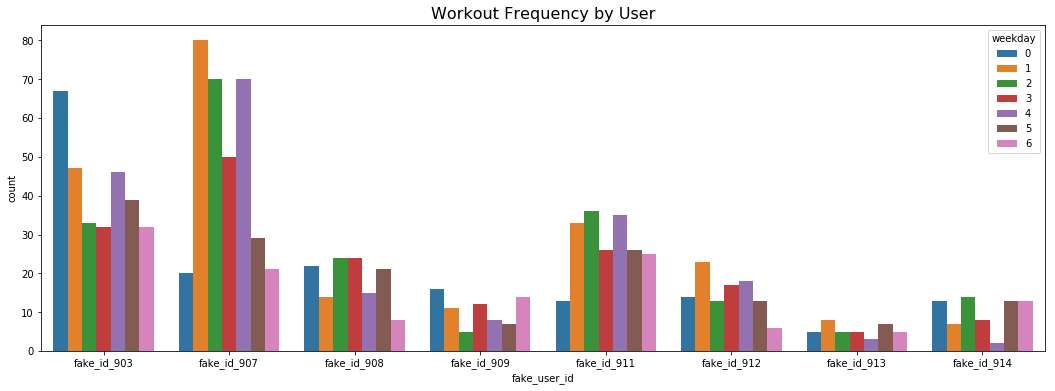

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
bar_plot=sns.barplot(x='fake_user_id', y='count',hue='weekday',data=df,ax=ax)
ax.set_title('Workout Frequency by User', fontsize=16)

plt.show()


In [53]:
table=pd.pivot_table(df, values='count', index=['fake_user_id'], columns=['weekday'], aggfunc=np.sum, fill_value=0)

In [54]:
# Create a table to capture workout time pattern
table

weekday,0,1,2,3,4,5,6
fake_user_id,,,,,,,
fake_id_903,67,47,33,32,46,39,32
fake_id_907,20,80,70,50,70,29,21
fake_id_908,22,14,24,24,15,21,8
fake_id_909,16,11,5,12,8,7,14
fake_id_911,13,33,36,26,35,26,25
fake_id_912,14,23,13,17,18,13,6
fake_id_913,5,8,5,5,3,7,5
fake_id_914,13,7,14,8,2,13,13


In [55]:
df_byExerciseName=data.groupby(['fake_user_id','exerciseName'])['singleSetId'].count().to_frame().reset_index()

In [56]:
df_byExerciseName

,fake_user_id,exerciseName,singleSetId
0,fake_id_903,Air Squats,42
1,fake_id_903,Alternating Medicine Ball Push Up,5
2,fake_id_903,Arnold Dumbbell Press,7
3,fake_id_903,Back Extensions,116
4,fake_id_903,Back Squat,13
...,...,...,...
1811,fake_id_914,Tuck Crunch,5
1812,fake_id_914,Upright Row,14
1813,fake_id_914,Vertical Knee Raise,3
1814,fake_id_914,Weighted Wall Sit,11


In [60]:
table2=pd.pivot_table(df_byExerciseName, values='singleSetId', index=['fake_user_id'], columns=['exerciseName'],aggfunc=np.sum, fill_value=0)
table2.head()

exerciseName,Ab Crunch Machine,Ab Rollout,Abs Bike,Abs Complex,Air Squats,Alternating Medicine Ball Push Up,Alternating Single Arm Kettlebell Swing,Arnold Dumbbell Press,Around the Worlds,Assisted Chin Up,...,Wall Ball,Wall Pectoral Stretch,Wall Sit,Wall Slide Stretch,Weighted Ball Hyperextension,Weighted Wall Sit,Wide Grip Lat Pulldown,Wide Grip Pull Up,Zottman Curl,Zottman Preacher Curl
fake_user_id,,,,,,,,,,,,,,,,,,,,,
fake_id_903,0,0,0,0,42,5,0,7,0,0,...,0,0,0,0,0,0,21,7,0,0
fake_id_904,14,0,0,0,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fake_id_905,4,26,7,7,0,0,0,13,0,0,...,9,0,0,0,0,0,29,3,3,0
fake_id_906,0,14,0,0,0,0,0,50,0,0,...,0,0,0,0,0,0,0,8,0,0
fake_id_907,0,0,3,0,171,0,0,13,6,0,...,0,6,1,0,6,2,0,0,51,0


In [61]:
table_master=table2.merge(table,on='fake_user_id')

In [62]:
table_master

,Ab Crunch Machine,Ab Rollout,Abs Bike,Abs Complex,Air Squats,Alternating Medicine Ball Push Up,Alternating Single Arm Kettlebell Swing,Arnold Dumbbell Press,Around the Worlds,Assisted Chin Up,...,Wide Grip Pull Up,Zottman Curl,Zottman Preacher Curl,0,1,2,3,4,5,6
fake_user_id,,,,,,,,,,,,,,,,,,,,,
fake_id_903,0,0,0,0,42,5,0,7,0,0,...,7,0,0,67,47,33,32,46,39,32
fake_id_907,0,0,3,0,171,0,0,13,6,0,...,0,51,0,20,80,70,50,70,29,21
fake_id_908,21,0,28,0,37,0,25,29,0,6,...,0,0,28,22,14,24,24,15,21,8
fake_id_909,0,0,5,0,0,3,0,3,0,0,...,4,8,0,16,11,5,12,8,7,14
fake_id_911,54,0,0,0,3,0,0,16,0,26,...,10,0,0,13,33,36,26,35,26,25
fake_id_912,7,20,0,0,1,0,0,6,0,0,...,8,0,0,14,23,13,17,18,13,6
fake_id_913,0,5,0,0,26,7,3,0,0,4,...,0,0,0,5,8,5,5,3,7,5
fake_id_914,0,0,0,0,5,0,0,0,0,0,...,0,0,0,13,7,14,8,2,13,13


In order to perform clustering, we need to reduce the dimension of our dataset. 
The main idea of principal component analysis (PCA) is to reduce the dimensionality of a data set 
consisting of many variables correlated with each other while retaining the variation present in the dataset, 
up to the maximum extent.

As a layman, it is a method of summarizing data.

## 3.1 PCA

In [63]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
x = StandardScaler().fit_transform(table_master)

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

In [71]:
principalDf

,0,1,2,3,4,5,6,7
0,-1.205037,-4.395625,-4.537379,2.085314,15.838363,-1.864619,0.310052,2.565564e-15
1,29.066266,-0.758541,2.961606,0.897786,-1.420406,0.723377,-0.441157,2.565564e-15
2,-3.350235,26.044602,0.427935,-1.765229,0.674881,0.723902,-0.249860,2.565564e-15
3,-4.989966,-5.462660,-5.752214,-1.286518,-1.915411,13.421808,0.813758,2.565564e-15
4,-7.455399,-5.736374,20.866415,-4.894396,0.280991,-0.367809,-0.038281,2.565564e-15
5,-6.467949,-1.665568,0.895367,16.383535,-4.864927,-2.303829,-1.401345,2.565564e-15
6,-3.321933,-4.725337,-8.332056,-7.237748,-3.963982,-4.749323,-8.948697,2.565564e-15
7,-2.275747,-3.300497,-6.529674,-4.182744,-4.629508,-5.583508,9.955529,2.565564e-15


In [72]:
print(pca.explained_variance_ratio_)  

[2.82970278e-01 2.26409379e-01 1.73550789e-01 1.05733344e-01
 9.03089530e-02 6.92737440e-02 5.17535129e-02 1.49593587e-32]


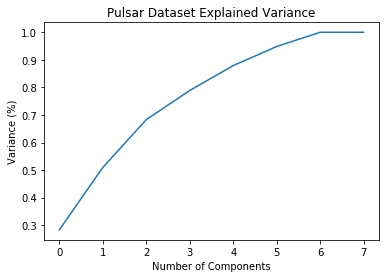

In [73]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

In [75]:
principalDf

,0,1,2,3,4
0,-1.205037,-4.395625,-4.537379,2.085314,15.838363
1,29.066266,-0.758541,2.961606,0.897786,-1.420406
2,-3.350235,26.044602,0.427935,-1.765229,0.674881
3,-4.989966,-5.462660,-5.752214,-1.286518,-1.915411
4,-7.455399,-5.736374,20.866415,-4.894396,0.280991
5,-6.467949,-1.665568,0.895367,16.383535,-4.864927
6,-3.321933,-4.725337,-8.332056,-7.237748,-3.963982
7,-2.275747,-3.300497,-6.529674,-4.182744,-4.629508


## 3.2 Kmeans Clutsering

K-Means starts by randomly defining k centroids. Assign each data point to the closest corresponding centroid, using the standard Euclidean distance. In layman's terms: the straight-line distance between the data point and the centroid

In [76]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(principalDf)

In [77]:
kmeans.cluster_centers_

array([[-3.35023453, 26.04460156,  0.42793539, -1.7652285 ,  0.67488061],
       [-4.28600527, -4.21434335, -0.56492359,  0.14457379,  0.12425417],
       [29.06626614, -0.75854143,  2.96160614,  0.89778578, -1.42040566]])

In [78]:
label=dict(zip(table_master.index,kmeans.labels_))

In [79]:
label

{'fake_id_903': 1,
 'fake_id_907': 2,
 'fake_id_908': 0,
 'fake_id_909': 1,
 'fake_id_911': 1,
 'fake_id_912': 1,
 'fake_id_913': 1,
 'fake_id_914': 1}

User 903, 909, 911, 912, 913, 914 have similar workout patterns.

# 4. Summary


1. Time Series Analysis<br>
    - In general, our time series has a upward trend.
    - The year by year increasement is growing exponentially.
    - Users tend to work out more on weekdays and during summer time.
    - The difference between workout on weekdays and weekends are increasing over years.


2. Apriori Analysis<br>
    - Handle Band Rear Deltoid Fly, Handle Band Bent Over Row => Loop Band Shoulder Squeeze	
    - Handle Band Bent Over Row =>	Handle Band Rear Deltoid Fly
    - These association rules can serve as a reference when we trying to creat workout recommendation or workout groups.
    

3. Kmean Clustering<br>
    - User 903, 909, 911, 912, 913, 914 have similar workout patterns. We can introduce them to each other thus to further increse user retention by leveraging network effect.